In [54]:
# import statsmodels.tsa as tsm
import statsmodels as sm
import statsmodels.tsa
import numpy as np
from numpy.random import normal as rnorm # random number generation

import matplotlib.pyplot as plt

# Time Series: Simulating an AR(1) Process

## A random walk

In [21]:
n = 100
sig = 1
ar1 = 0.5
time_vec = np.array(range(n))

In [22]:
noise = rnorm(loc=0, scale=sig, size=n)


The simplest form of a time series process is probably a random walk. To achieve this, we just take the cummulative sum of the random normal noise.

In [23]:
rw = np.cumsum(noise)

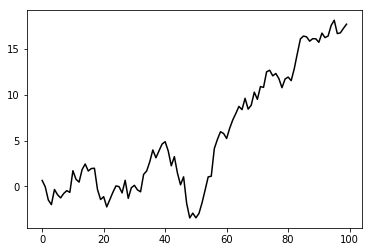

In [24]:
plt.plot(time_vec, rw, color='black')

To give a better sense of the different types of outcomes, we will define a function to generate a random walk, the plot a few realizations of this process.

In [29]:
def gen_rw(n=100, sig=1):
    """
    n = length of time series
    sig = standard deviation of innovations
    """
    noise = rnorm(loc=0, scale=sig, size=n)
    rw = np.cumsum(noise)
    return rw
    

    

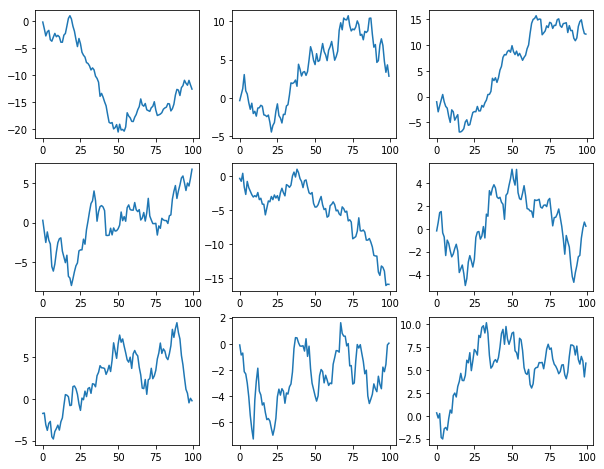

In [34]:
plt.subplots(3,3, figsize=(10,8))
n2 = 100
time_vec = np.array(range(n2))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.plot(time_vec, gen_rw())

Note how many of these time series look like they might have some sort of deterministic pattern ... such as cycles, trends, or abrupt shifts in mean. 

All of these are essentially an AR(1) process where the coefficient is 1:

$$x_t = \varphi \times x_t-1 + \epsilon_t$$

Note that $\epsilon_t \sim N(0,1)$, and that $\varphi=1$ in these examples. But we can change the variance of the noise generating process, as well as the AR(1) coefficient, $\varphi$. 

## An AR(1) when $\varphi \neq 1$

In [71]:
import statsmodels.tsa.arima_process
ar1_proc = sm.tsa.arima_process.ArmaProcess(ar=(1,0.5))
ar1_realiz = ar1_proc.generate_sample(100)

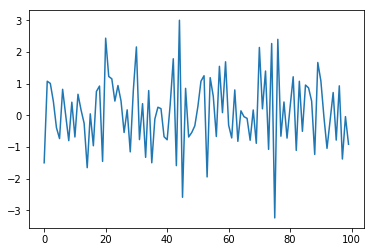

In [73]:
plt.plot(ar1_realiz)

As you can see, a smaller AR(1) coefficient leads to a process that decays back to 0 much faster.

But let's write our own function to simulate an AR(1), just so it's more obvious what's going on.

In [79]:
def sim_ar1(ar1_coef=0.5, sig=1, n=100):
    vec = [None]*n # state vector
    noise = np.random.normal(loc=0, scale=sig, size=n) # noise vector
    vec[0] = noise[0] # initialize from random, or 0; only important in OE-only model
    
    for i in range(1, n): # initialize loop after first obs, so have a x_{t-1}
        vec[i] = vec[i-1]*ar1_coef + noise[i]
    
    return(vec)

small_c = 0.25
big_c = 0.95
ar_small = sim_ar1(small_c)
ar_big = sim_ar1(big_c)
        
        

Text(0.5,1,'AR(1) = 0.95')

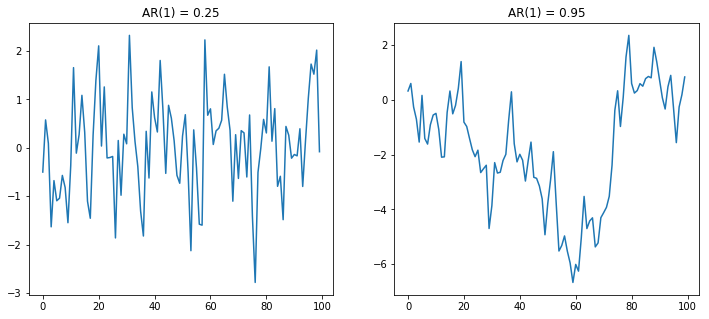

In [83]:
plt.subplots(1,2, figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(ar_small)
plt.title('AR(1) = '+str(small_c))
plt.subplot(1,2,2)
plt.plot(ar_big)
plt.title('AR(1) = '+str(big_c))

# Estimating $\varphi$ in an AR(1) Model

In [146]:
import statsmodels.tsa.ar_model
dat = sim_ar1(0.5, n=1000, sig=0.1)
ar1_mod = sm.tsa.ar_model.AR(dat)
ar1_fit = ar1_mod.fit(1)
ar1_fit.params

array([0.00270573, 0.50400326])

In [162]:
import scipy.stats
import pandas as pd
def ar1_nll_pe(x0, x):
    # unpack parameters
    phi = x0[0]
    sig = x0[1]
    
    # obs and pred, as arrays
    x = np.array(x)
    n = len(x)
    x_hat = np.array([None]*n)
    
    # iterate through predictions
    x_hat[0] = x[0] # Implications of this choice?
    for i in range(1,n):
        x_hat[i] = phi*x[i-1] # x, or x_hat?
    
    # compute residuals and nll
    res = list(x - x_hat)
    nll = -sum(scipy.stats.norm.logpdf(x=res, loc=0, scale=sig))
    
    return nll

print('NLL when \hat_{phi} = 0.9: '+ str(ar1_nll_pe(x0=[0.9,0.1], x=dat)))
print('NLL when \hat_{phi} = 0.5: '+ str(ar1_nll_pe(x0=[0.5,0.1], x=dat)))
print('NLL when \hat_{phi} = 0.1: '+ str(ar1_nll_pe(x0=[0.1,0.1], x=dat)))

NLL when \hat_{phi} = 0.9: -732.0654419541471
NLL when \hat_{phi} = 0.5: -844.7132437381235
NLL when \hat_{phi} = 0.1: -726.2317841023952


In [164]:
import scipy.stats
import pandas as pd
def ar1_nll_oe(x0, x):
    # unpack parameters
    phi = x0[0]
    sig = x0[1]
    x_init = x[2] # this is new!
    
    # obs and pred, as arrays
    x = np.array(x)
    n = len(x)
    x_hat = np.array([None]*n)
    
    # iterate through predictions
    x_hat[0] = x_init # Implications of this choice?
    for i in range(1,n):
        x_hat[i] = phi*x_hat[i-1] # x, or x_hat?
    
    # compute residuals and nll
    res = list(x - x_hat)
    nll = -sum(scipy.stats.norm.logpdf(x=res, loc=0, scale=sig))
    
    return nll

print('NLL when \hat_{phi} = 0.9: '+ str(ar1_nll_oe(x0=[0.9,0.1,0], x=dat)))
print('NLL when \hat_{phi} = 0.5: '+ str(ar1_nll_oe(x0=[0.5,0.1,0], x=dat)))
print('NLL when \hat_{phi} = 0.1: '+ str(ar1_nll_oe(x0=[0.1,0.1,0], x=dat)))

NLL when \hat_{phi} = 0.9: -660.0492659006245
NLL when \hat_{phi} = 0.5: -660.0137506841847
NLL when \hat_{phi} = 0.1: -659.991521374712


Performance is clearly worse in the second case. But consider the difference between them ... what are the sources of error in the two variations?

The first model is a 'process error' model. It is assumed our observations are perfect, but that our model describing the process is uncertain. In this model, we predict x_t from the observed value at the last time step b/c this obseration is *known* AND *perfect* (or so we assume). With this formulation, if our predictions for x_t are imperfect, it's because the model formulation is wrong.

The second model is an 'observation error' model. It is assumed that our model is perfect (formulation .. still have to fit phi), but that our observations are flawed. Thus we are better off predicting x_t from our previous prediction of the state variable, rather than using the observation of the state variable. Note that the highest likelihood still occurs when observation variance (**sig**) is small, so minimizing the NLL still promotes fitting the correct phi value.

In the observation error model, we had to fit the initial observation as a parameter. Why does this matter? Well, remember that we assume only our observations are flawed, and that we drive our predictions foward using previous predictions, not observations. So we want to start this process using a predicted value, not a potentially-flawed observation.